<a href="https://colab.research.google.com/github/hifsakazmi/computer-vision-in-python/blob/main/Butterfly_Image_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Butterfly and Moth Image Classification Through Transfer Learning

## Project Description

* For this project, I am going to load Butterfly and Moths dataset ([Dataset Link](https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species/)) from Kaggle.
* The scope is this project is image classification of top 10 classes with highest number of images.
* For image classification, first I am going to use pre-trained **MobileNetV2** from Keras. Next, I will fine-tune that model and compare performance of pre-trained and fine-tuned models.

## Importing the Libraries

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

## Downloading Dataset from Kagglehub

In [61]:
import kagglehub

# Download latest version of butterflies and moths dataset
path = kagglehub.dataset_download("gpiosenka/butterfly-images40-species")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13


## Exploratory Data Anaylsis

In [62]:
import os

os.listdir(path)

['valid',
 'train',
 'EfficientNetB0-100-(224 X 224)- 97.59.h5',
 'test',
 'training.csv.csv',
 'butterflies and moths.csv']

* The dataset has **train**, **test** and **valid** directories with train, test and validation image datasets, respectively.
* There is also **butterflies and moths.csv** file. I am going to use pandas dataframe to further explore this file.

In [63]:
import pandas as pd

df = pd.read_csv(path + '/butterflies and moths.csv')
df.head()

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train


### Count Train, Test and Validation Data

In [64]:
df.groupby('data set').count()

,class id,filepaths,labels
data set,,,
test,500,500,500
train,12594,12594,12594
valid,500,500,500


In [65]:
def count_images(dir_path):
    count = 0
    for root, dirs , files in os.walk(dir_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                count += 1
    return count

In [66]:
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')
valid_dir = os.path.join(path, 'valid')

print(f"There are {count_images(train_dir)} images in train directory.")
print(f"There are {count_images(test_dir)} images in test directory.")
print(f"There are {count_images(valid_dir)} images in valid directory.")

There are 1567 images in train directory.
There are 50 images in test directory.
There are 50 images in valid directory.


### Find Unique Butterfly and Moth Classes

In [67]:
nspecies = df[df['data set'] == 'train'].labels.nunique()
print(f"There are {nspecies} species of butterflies and moths in this dataset.")

There are 100 species of butterflies and moths in this dataset.


In [68]:
df.labels.describe()

,labels
count,13594
unique,100
top,MOURNING CLOAK
freq,197


In [69]:
df.labels.value_counts()

,count
labels,
MOURNING CLOAK,197
GREEN HAIRSTREAK,186
BROWN ARGUS,179
BROOKES BIRDWING,175
SLEEPY ORANGE,162
...,...
ZEBRA LONG WING,114
CRIMSON PATCH,113
MALACHITE,113


**Findings:**
* There are 100 classes of butterflies and moths in this dataset.
* **MOURNING CLOAK** has the highest number (197) of images.
* **SIXSPOT BURNET MOTH** has the lowest number (110) of images.

In [70]:
#for dirpath, dirnames, filenames in os.walk(path):
#  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

### Find Top 10 Species in Dataset

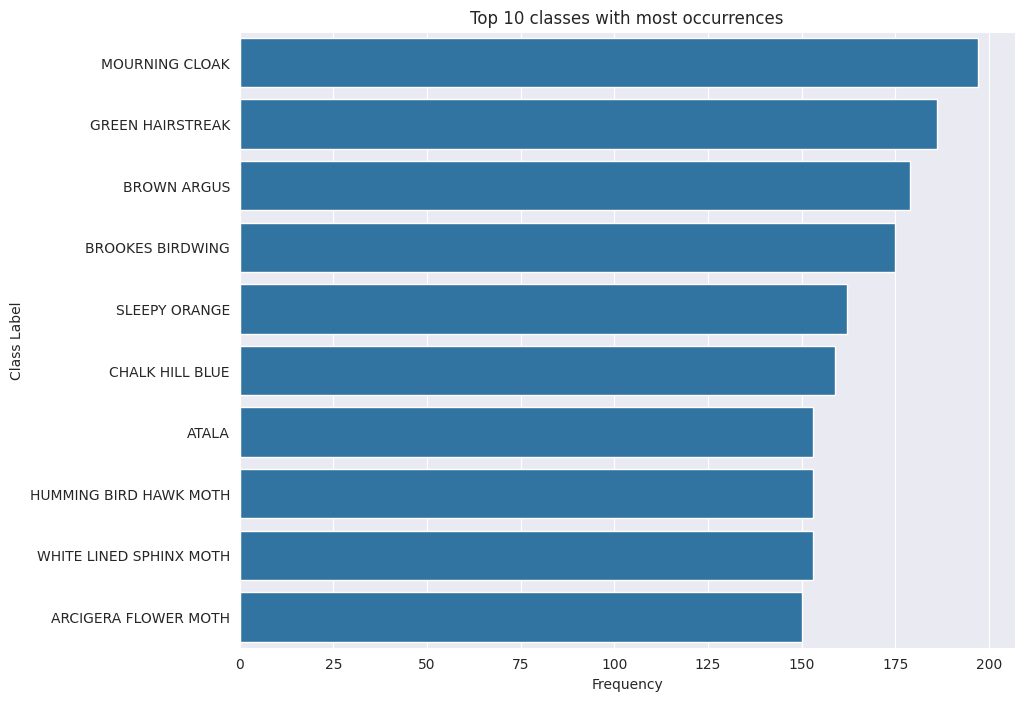

In [71]:
class_freq = {}
class_labels = df.labels
for label in class_labels:
    if label in class_freq:
        class_freq[label] +=1
    else:
        class_freq[label] = 1

# sort the classes by frequency in descending order
sorted_class = sorted(class_freq.items(),key=lambda x: x[1],reverse=True)
# print(sorted_class)
top_classes = dict(sorted_class[:10])
other_classes = dict(sorted_class[10:])

plt.figure(figsize=(10,8))
sns.countplot(y=class_labels, order=top_classes.keys())
plt.xlabel("Frequency")
plt.ylabel("Class Label")
plt.title("Top 10 classes with most occurrences")
plt.show();

### Remove Data to Only Include Top 10 Classes



For the scope of this project, I am only going to classify top 10 most occuring classes in the dataset. Therefore, following steps will remove images belonging to classes **NOT in Top 10**.

In [72]:
# Reduce the size of dataset to only include Top 10 classes
top_df = df[df['labels'].isin(top_classes)]

top_df.labels.value_counts()

,count
labels,
MOURNING CLOAK,197
GREEN HAIRSTREAK,186
BROWN ARGUS,179
BROOKES BIRDWING,175
SLEEPY ORANGE,162
CHALK HILL BLUE,159
ATALA,153
HUMMING BIRD HAWK MOTH,153
WHITE LINED SPHINX MOTH,153


In [73]:
import shutil

# Creating a function to remove directories that don't have a top 10 species
def remove_dirs(dir_path, other_classes):
    for specie in other_classes:
      specie_path = os.path.join(dir_path, specie)
      try:
        shutil.rmtree(specie_path)
      except Exception as ex:
        #print('Folder not deleted: ', specie_path)
        #print(ex)
        pass

In [74]:
# Removing directories from train, test, valid data
remove_dirs(train_dir, other_classes)
remove_dirs(test_dir, other_classes)
remove_dirs(valid_dir, other_classes)

In [75]:
print(f"There are {count_images(train_dir)} images in train directory.")
print(f"There are {count_images(test_dir)} images in test directory.")
print(f"There are {count_images(valid_dir)} images in valid directory.")

There are 1567 images in train directory.
There are 50 images in test directory.
There are 50 images in valid directory.


## Creating Train, Test and Validation Sets

In [76]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1567 files belonging to 10 classes.
Found 50 files belonging to 10 classes.
Found 50 files belonging to 10 classes.


In [77]:
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Labels: [7 0 5 6 1 2 7 5 1 3 3 3 5 2 4 4 1 3 7 9 2 1 3 6 1 8 6 3 5 2 3 8]


In [78]:
class_names = train_dataset.class_names
print(class_names)

['ARCIGERA FLOWER MOTH', 'ATALA', 'BROOKES BIRDWING', 'BROWN ARGUS', 'CHALK HILL BLUE', 'GREEN HAIRSTREAK', 'HUMMING BIRD HAWK MOTH', 'MOURNING CLOAK', 'SLEEPY ORANGE', 'WHITE LINED SPHINX MOTH']


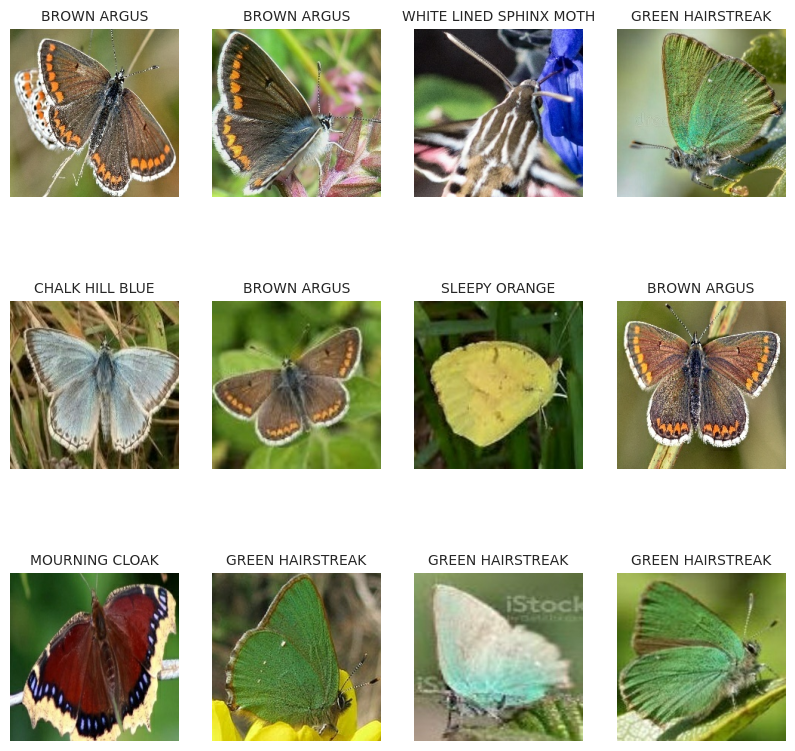

In [79]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]], fontsize=10)
    plt.axis("off")

## Loading MobileNetV2 Model

In [80]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [81]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [82]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [83]:
base_model.trainable = False

In [84]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Adding Custom Top to Pre-trained MobileNetV2

In [85]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [86]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [87]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [88]:
inputs = tf.keras.Input(shape=(224, 224, 3))

In [89]:
dropout_layer = tf.keras.layers.Dropout(0.2)

In [90]:
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [91]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [92]:
len(model.trainable_variables)

2

## Train the Model

In [93]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [94]:
EPOCHS = 10

In [95]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.1396 - loss: 2.4431 - val_accuracy: 0.3200 - val_loss: 1.8486
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3335 - loss: 1.8912 - val_accuracy: 0.5800 - val_loss: 1.4120
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5418 - loss: 1.4882 - val_accuracy: 0.8000 - val_loss: 1.1058
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6700 - loss: 1.1931 - val_accuracy: 0.8800 - val_loss: 0.8875
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7769 - loss: 0.9781 - val_accuracy: 0.8800 - val_loss: 0.7277
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8120 - loss: 0.8561 - val_accuracy: 0.8800 - val_loss: 0.6101
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8623 - loss: 0.7077 - val_accuracy: 0.9000 - val_loss: 0.5226
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8759 - loss: 0.6207 - val_accuracy: 0.9600 - val_loss:

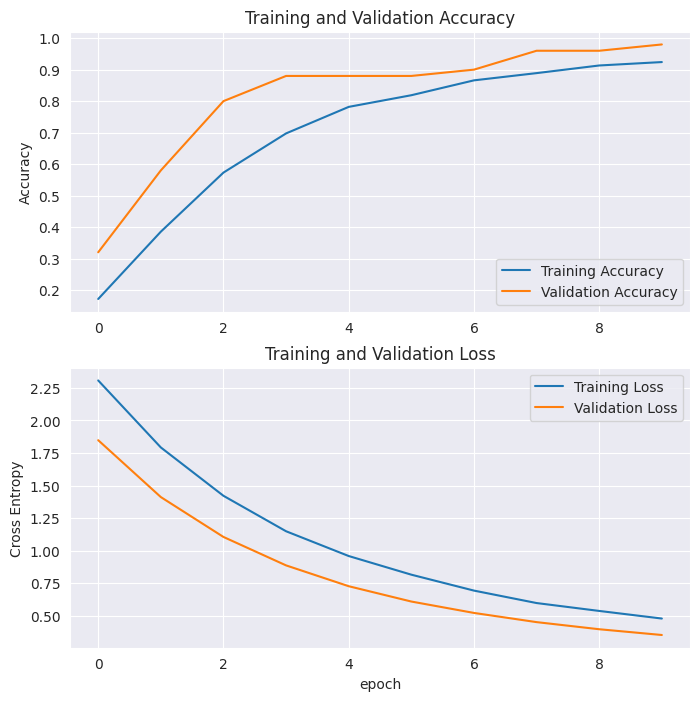

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Confusion Matrix and Classification Report

In [97]:
# Get predictions for the test set
test_predictions = model.predict(test_dataset)
test_predicted_labels = np.argmax(test_predictions, axis=1)

1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


In [98]:
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

print(true_labels)
print(test_predicted_labels)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]
[0 0 0 0 0 1 3 1 1 1 2 1 2 2 2 3 3 3 3 3 4 5 3 5 4 5 5 5 5 5 6 6 6 0 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]


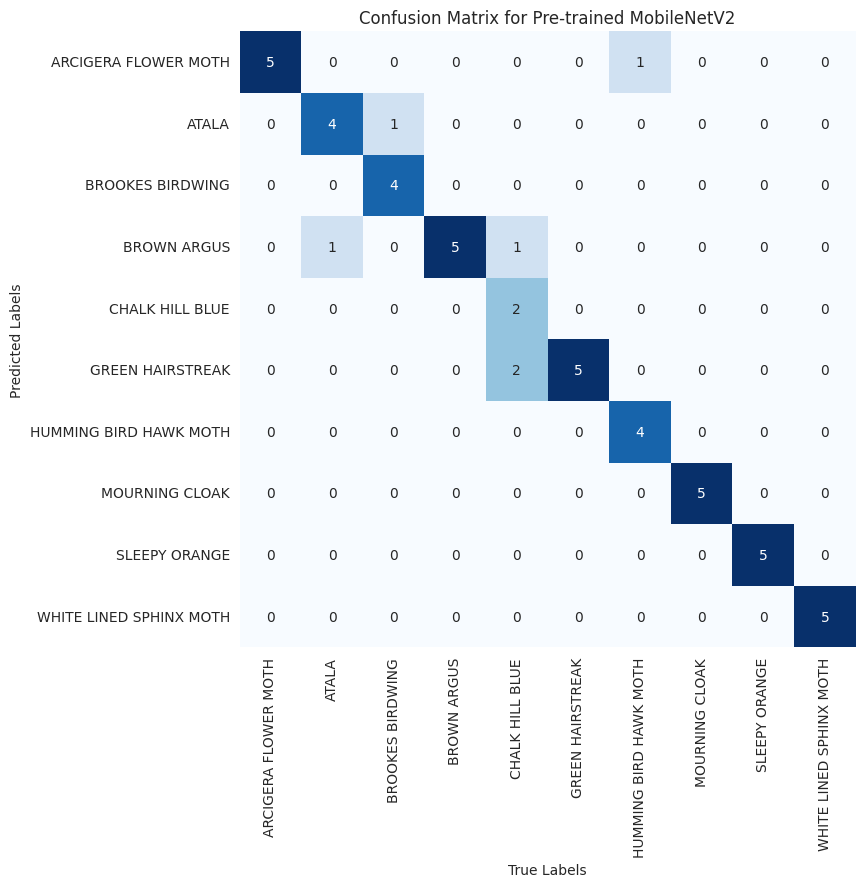

In [99]:
from sklearn.metrics import classification_report,confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, test_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix for Pre-trained MobileNetV2')
plt.show()

In [100]:
print(classification_report(true_labels, test_predicted_labels, target_names=class_names))

                         precision    recall  f1-score   support

   ARCIGERA FLOWER MOTH       0.83      1.00      0.91         5
                  ATALA       0.80      0.80      0.80         5
       BROOKES BIRDWING       1.00      0.80      0.89         5
            BROWN ARGUS       0.71      1.00      0.83         5
        CHALK HILL BLUE       1.00      0.40      0.57         5
       GREEN HAIRSTREAK       0.71      1.00      0.83         5
 HUMMING BIRD HAWK MOTH       1.00      0.80      0.89         5
         MOURNING CLOAK       1.00      1.00      1.00         5
          SLEEPY ORANGE       1.00      1.00      1.00         5
WHITE LINED SPHINX MOTH       1.00      1.00      1.00         5

               accuracy                           0.88        50
              macro avg       0.91      0.88      0.87        50
           weighted avg       0.91      0.88      0.87        50



### Evaluate the Model

In [101]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test accuracy :', test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 623ms/step - accuracy: 0.8679 - loss: 0.5013
Test accuracy : 0.8799999952316284


## Fine-Tuning the Model

In [102]:
# Printing the number of layers are in our base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [103]:
# In order to train layers in the model, trainable parameter must be set to True
base_model.trainable = True

In [104]:
# Fine-tune from this layer onwards
fine_tune_at = 125

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [105]:
len(model.trainable_variables)

32

In [106]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=["accuracy"])

In [107]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 1,538,890 (5.87 MB)

 Non-trainable params: 731,904 (2.79 MB)

In [108]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7864 - loss: 0.6926 - val_accuracy: 0.8800 - val_loss: 0.2335
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9956 - loss: 0.0425 - val_accuracy: 0.9600 - val_loss: 0.1390
Epoch 13/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9994 - loss: 0.0246 - val_accuracy: 0.9600 - val_loss: 0.1211
Epoch 14/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0744
Epoch 15/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0485
Epoch 16/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0268
Epoch 17/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0212
Epoch 18/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0

In [109]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

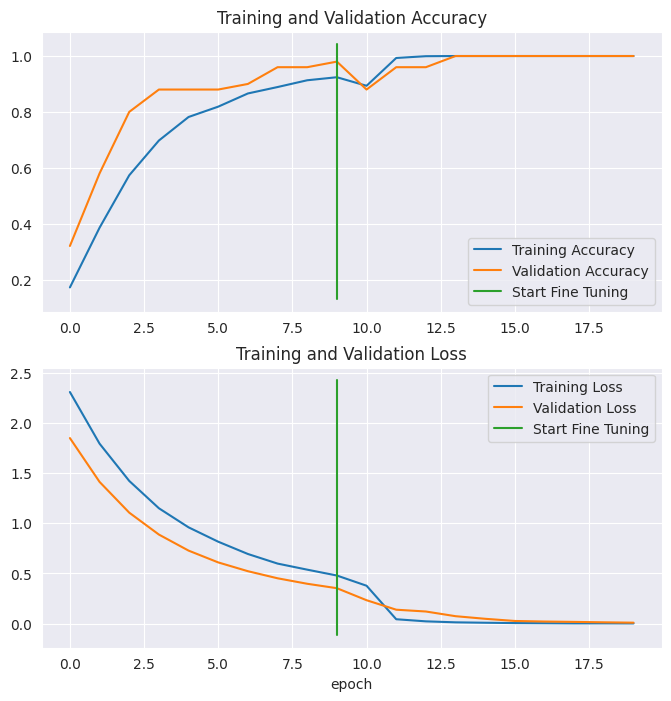

In [110]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluate Fine-tuned Model

In [111]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9154 - loss: 0.1979
Test accuracy : 0.9200000166893005


Predictions:
 [0 0 0 0 0 1 3 1 1 1 2 1 2 2 2 3 3 3 3 3 4 4 3 4 4 5 5 5 5 5 6 6]
Labels:
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6]


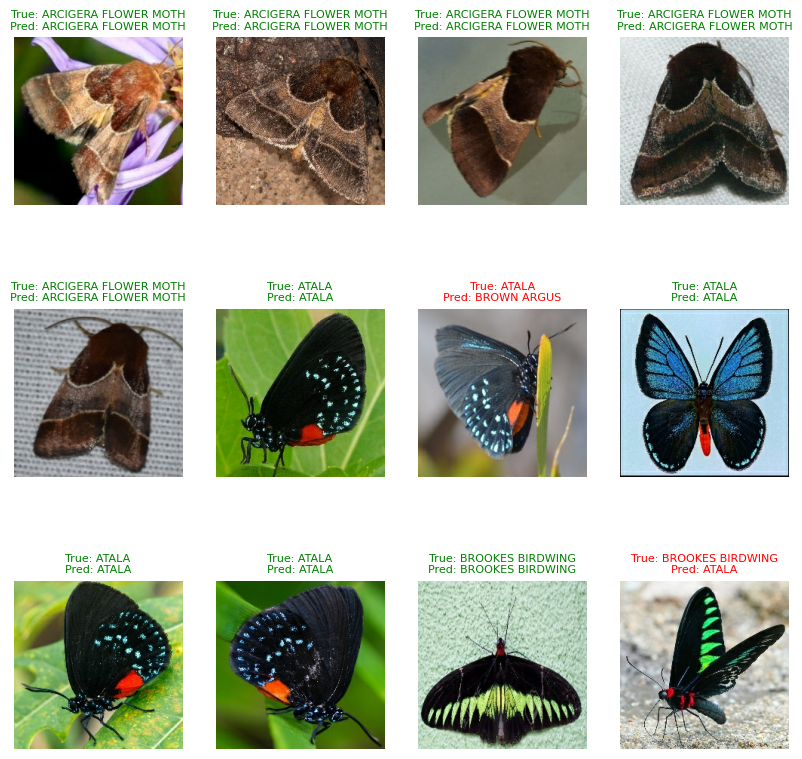

In [112]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  true_label = class_names[label_batch[i]]  # Get true label
  predicted_label = class_names[predicted_classes[i]]  # Get predicted label

  if true_label == predicted_label:
    color = 'green'  # Correct prediction
  else:
    color = 'red'  # Incorrect prediction
  plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color, fontsize=8)
  #plt.title(class_names[predicted_classes[i]], fontsize=8)

  plt.axis("off")

### Confusion Matrix and Classification Report

In [113]:
# Get predictions for the test set
test_predictions_tuned = model.predict(test_dataset)
test_predicted_labels_tuned = np.argmax(test_predictions_tuned, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


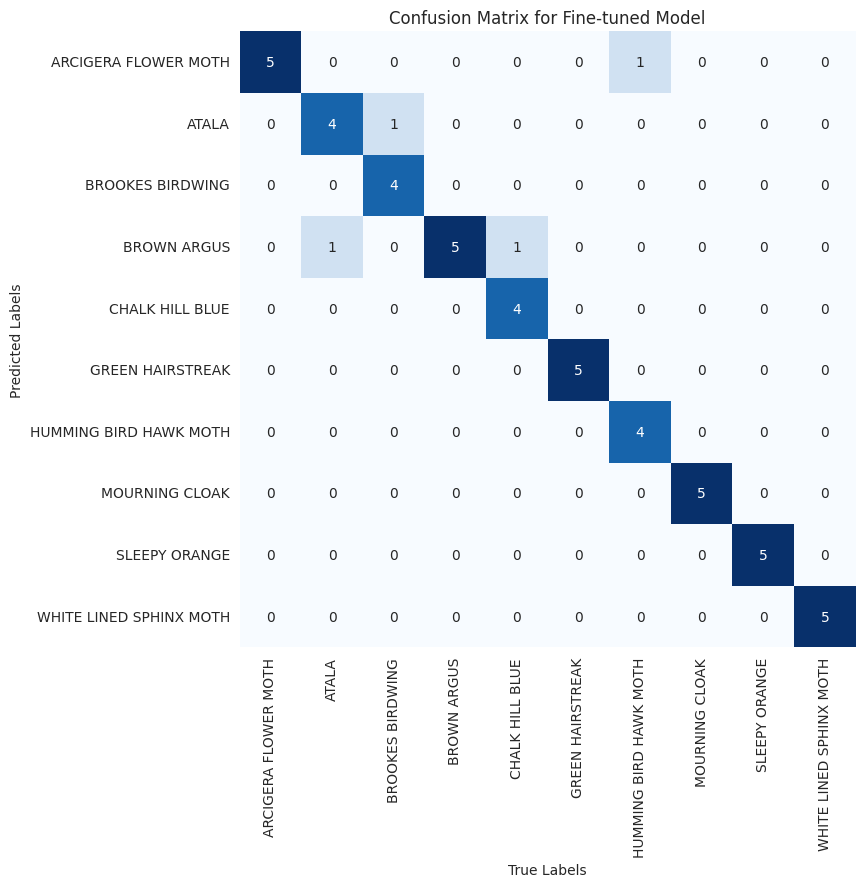

In [114]:
# Calculate the confusion matrix for fine-tuned model
cm = confusion_matrix(true_labels, test_predicted_labels_tuned)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix for Fine-tuned Model')
plt.show()

In [115]:
print(classification_report(true_labels, test_predicted_labels_tuned, target_names=class_names))

                         precision    recall  f1-score   support

   ARCIGERA FLOWER MOTH       0.83      1.00      0.91         5
                  ATALA       0.80      0.80      0.80         5
       BROOKES BIRDWING       1.00      0.80      0.89         5
            BROWN ARGUS       0.71      1.00      0.83         5
        CHALK HILL BLUE       1.00      0.80      0.89         5
       GREEN HAIRSTREAK       1.00      1.00      1.00         5
 HUMMING BIRD HAWK MOTH       1.00      0.80      0.89         5
         MOURNING CLOAK       1.00      1.00      1.00         5
          SLEEPY ORANGE       1.00      1.00      1.00         5
WHITE LINED SPHINX MOTH       1.00      1.00      1.00         5

               accuracy                           0.92        50
              macro avg       0.93      0.92      0.92        50
           weighted avg       0.93      0.92      0.92        50



## Final Thoughts